# Locating acoustic and articulatory information in Wav2Vec2 with CKA

---

Author: Marianne de Heer Kloots

---

Representational space comparison methods such as Centered Kernel Alignment allow us to compare representational spaces with very different formats, such model embeddings and syntactic trees (as in [Shen et al., 2023](https://www.isca-archive.org/interspeech_2023/shen23_interspeech.html)), or model embeddings and human brain recordings (as in [de Heer Kloots et al., 2025](https://2025.ccneuro.org/abstract_pdf/Kloots_2025_The_role_context_neural_representational_alignment.pdf)), <!-- (as in [Abnar et al., 2019]()) --> as long as we are able to define a similarity measure over a common set of stimuli within each representational space.

In this notebook, we'll perform a representational similarity analysis technique called Centered Kernel Alignment ([Kornblith et al., 2019](https://proceedings.mlr.press/v97/kornblith19a/kornblith19a.pdf)), to compare Wav2Vec2's internal layer activations to articulatory EMA features and acoustic MFCC features.
For each type of feature (i.e. each _representation space_), we extract _Gram matrices_, capturing the pairwise similarities across all stimuli within that representation space. CKA in effect then scores the alignment between Gram matrices of different representation spaces, e.g. between Wav2Vec2 activations and EMA or MFCC features.

We'll also explore the use of CKA to compare layerwise activations within a model, characterizing its different processing stages.

This notebook makes use of the [reference code](https://colab.research.google.com/github/google-research/google-research/blob/master/representation_similarity/Demo.ipynb) provided by Simon Kornblith and colleagues for implementing CKA computations, which is loaded in the cell below.

TODO add picture visualizing articulatory feature vectors and MFCCs

In [ ]:
# @title CKA functions
## taken from Kornblith et al. (2019) - https://cka-similarity.github.io/
import numpy as np

def gram_linear(x):
  """Compute Gram (kernel) matrix for a linear kernel.

  Args:
    x: A num_examples x num_features matrix of features.

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  return x.dot(x.T)


def gram_rbf(x, threshold=1.0):
  """Compute Gram (kernel) matrix for an RBF kernel.

  Args:
    x: A num_examples x num_features matrix of features.
    threshold: Fraction of median Euclidean distance to use as RBF kernel
      bandwidth. (This is the heuristic we use in the paper. There are other
      possible ways to set the bandwidth; we didn't try them.)

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  dot_products = x.dot(x.T)
  sq_norms = np.diag(dot_products)
  sq_distances = -2 * dot_products + sq_norms[:, None] + sq_norms[None, :]
  sq_median_distance = np.median(sq_distances)
  return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))


def center_gram(gram, unbiased=False):
  """Center a symmetric Gram matrix.

  This is equvialent to centering the (possibly infinite-dimensional) features
  induced by the kernel before computing the Gram matrix.

  Args:
    gram: A num_examples x num_examples symmetric matrix.
    unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
      estimate of HSIC. Note that this estimator may be negative.

  Returns:
    A symmetric matrix with centered columns and rows.
  """
  if not np.allclose(gram, gram.T):
    raise ValueError('Input must be a symmetric matrix.')
  gram = gram.copy()

  if unbiased:
    # This formulation of the U-statistic, from Szekely, G. J., & Rizzo, M.
    # L. (2014). Partial distance correlation with methods for dissimilarities.
    # The Annals of Statistics, 42(6), 2382-2412, seems to be more numerically
    # stable than the alternative from Song et al. (2007).
    n = gram.shape[0]
    np.fill_diagonal(gram, 0)
    means = np.sum(gram, 0, dtype=np.float64) / (n - 2)
    means -= np.sum(means) / (2 * (n - 1))
    gram -= means[:, None]
    gram -= means[None, :]
    np.fill_diagonal(gram, 0)
  else:
    means = np.mean(gram, 0, dtype=np.float64)
    means -= np.mean(means) / 2
    gram -= means[:, None]
    gram -= means[None, :]

  return gram


def cka(gram_x, gram_y, debiased=False):
  """Compute CKA.

  Args:
    gram_x: A num_examples x num_examples Gram matrix.
    gram_y: A num_examples x num_examples Gram matrix.
    debiased: Use unbiased estimator of HSIC. CKA may still be biased.

  Returns:
    The value of CKA between X and Y.
  """
  gram_x = center_gram(gram_x, unbiased=debiased)
  gram_y = center_gram(gram_y, unbiased=debiased)

  # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
  # n*(n-3) (unbiased variant), but this cancels for CKA.
  scaled_hsic = gram_x.ravel().dot(gram_y.ravel())

  normalization_x = np.linalg.norm(gram_x)
  normalization_y = np.linalg.norm(gram_y)
  return scaled_hsic / (normalization_x * normalization_y)


def _debiased_dot_product_similarity_helper(
    xty, sum_squared_rows_x, sum_squared_rows_y, squared_norm_x, squared_norm_y,
    n):
  """Helper for computing debiased dot product similarity (i.e. linear HSIC)."""
  # This formula can be derived by manipulating the unbiased estimator from
  # Song et al. (2007).
  return (
      xty - n / (n - 2.) * sum_squared_rows_x.dot(sum_squared_rows_y)
      + squared_norm_x * squared_norm_y / ((n - 1) * (n - 2)))


def feature_space_linear_cka(features_x, features_y, debiased=False):
  """Compute CKA with a linear kernel, in feature space.

  This is typically faster than computing the Gram matrix when there are fewer
  features than examples.

  Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.
    debiased: Use unbiased estimator of dot product similarity. CKA may still be
      biased. Note that this estimator may be negative.

  Returns:
    The value of CKA between X and Y.
  """
  features_x = features_x - np.mean(features_x, 0, keepdims=True)
  features_y = features_y - np.mean(features_y, 0, keepdims=True)

  dot_product_similarity = np.linalg.norm(features_x.T.dot(features_y)) ** 2
  normalization_x = np.linalg.norm(features_x.T.dot(features_x))
  normalization_y = np.linalg.norm(features_y.T.dot(features_y))

  if debiased:
    n = features_x.shape[0]
    # Equivalent to np.sum(features_x ** 2, 1) but avoids an intermediate array.
    sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
    sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
    squared_norm_x = np.sum(sum_squared_rows_x)
    squared_norm_y = np.sum(sum_squared_rows_y)

    dot_product_similarity = _debiased_dot_product_similarity_helper(
        dot_product_similarity, sum_squared_rows_x, sum_squared_rows_y,
        squared_norm_x, squared_norm_y, n)
    normalization_x = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_x ** 2, sum_squared_rows_x, sum_squared_rows_x,
        squared_norm_x, squared_norm_x, n))
    normalization_y = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_y ** 2, sum_squared_rows_y, sum_squared_rows_y,
        squared_norm_y, squared_norm_y, n))

  return dot_product_similarity / (normalization_x * normalization_y)

The cell below loads libraries and data used in this notebook. First make sure to connect to the tutorial folder in your google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

TUTORIAL_PATH = '/content/drive/MyDrive/InterspeechTutorial'

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import pickle
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
sns.set_style('whitegrid')

# audio sampling frequency
SAMP_FREQ = 16000

# filenames for for two participants speaking a set of 10 identical sentences
p1_filenames = ['F02_B01_S18_R01_N.mat', 'F02_B01_S33_R01_N.mat', 'F02_B01_S04_R01_N.mat', 'F02_B01_S52_R01_N.mat', 'F02_B01_S42_R01_N.mat']
p2_filenames = ['M02_B01_S18_R01_N.mat', 'M02_B01_S33_R01_N.mat', 'M02_B01_S04_R01_N.mat', 'M02_B01_S52_R01_N.mat', 'M02_B01_S42_R01_N.mat']

# wav2vec2 features extracted for the 10 sentence recordings by participant 1 and 2
frame_states_p1_test = pickle.load(open(f'{TUTORIAL_PATH}/ema_probing_data/frame_states_p1_test.pkl', 'rb'))
frame_states_p2_test = pickle.load(open(f'{TUTORIAL_PATH}/ema_probing_data/frame_states_p2_test.pkl', 'rb'))

# audio and electromagnetic articulography (EMA) data for sentences read by participant 1
audio_df_p1 = pd.read_pickle(f'{TUTORIAL_PATH}/ema_probing_data/ema_audio_F02.pkl')
audio_df_p1 = audio_df_p1[audio_df_p1['FILENAME'].str.contains('B01')].reset_index()
ema_features_p1 = pd.read_csv(f'{TUTORIAL_PATH}/ema_probing_data/ema_labels_F02.csv')
ema_features_p1 = ema_features_p1[ema_features_p1['FILENAME'].str.contains('B01')].reset_index()

# names of the X and Y coordinates recorded by EMA
ema_X_feats = ['TR_X', 'TB_X', 'TT_X', 'UL_X', 'LL_X', 'JAW_X']
ema_Y_feats = ['TR_Y', 'TB_Y', 'TT_Y', 'UL_Y', 'LL_Y', 'JAW_Y']

## CKA similarity to acoustic and articulatory features

Is acoustic information equally prominent across all layers of Wav2Vec2? What about articulatory information?

In [ ]:
def mfcc_cka(frame_states, filenames, audio_df):
    """
    This function computes layerwise CKA similarity scores between model frame states
    and acoustic MFCC features, over a joint set of audio recordings (filenames).
    """
    cka_results = []
    for filename in filenames:
        N_frame_states = len(np.array(frame_states[0][filename]))
        audio = audio_df[audio_df['FILENAME'] == filename]['AUDIO'].values[0]

        # truncate MFCC features to the same length as number of frame states
        # (TODO: check if this is valid)
        mfcc_features = librosa.feature.mfcc(
            y=audio, sr=SAMP_FREQ, n_mels=18, n_fft=320, hop_length=len(audio)//N_frame_states
        ).T[:N_frame_states]

        for layer in frame_states.keys():
            layer_states = np.array(frame_states[layer][filename])
            cka_score = cka(gram_linear(layer_states), gram_linear(mfcc_features))
            cka_results.append(('MFCC', filename, layer, cka_score))
    cka_results_df = pd.DataFrame(cka_results, columns=['feature', 'filename', 'model_layer', 'cka_score'])
    return cka_results_df

def ema_cka(frame_states, filenames, ema_df, ema_feature_names):
    """
    This function computes layerwise CKA similarity scores between model frame states
    and articulatory EMA features, over a joint set of audio recordings (filenames).
    """
    cka_results = []
    for filename in filenames:
        N_frame_states = len(np.array(frame_states[0][filename]))

        # truncate EMA features to the same length as number of frame states
        # (TODO: check if this is valid)
        ema_features = ema_df[
            ema_df['FILENAME'] == filename
        ][ema_feature_names][:N_frame_states].values

        for layer in frame_states.keys():
            layer_states = np.array(frame_states[layer][filename])
            cka_score = cka(gram_linear(layer_states), gram_linear(ema_features))
            cka_results.append(('EMA', filename, layer, cka_score))
    cka_results_df = pd.DataFrame(cka_results, columns=['feature', 'filename', 'model_layer', 'cka_score'])
    return cka_results_df

In [ ]:
mfcc_cka_results = mfcc_cka(frame_states_p1_test, p1_filenames, audio_df_p1)
ema_cka_results = ema_cka(frame_states_p1_test, p1_filenames, ema_features_p1, ema_X_feats + ema_Y_feats)

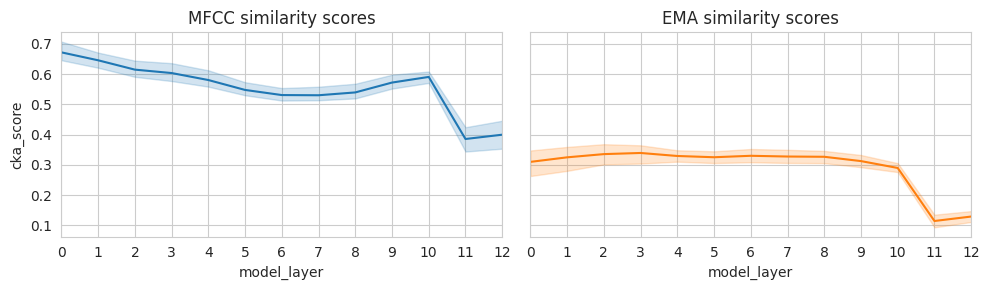

In [ ]:
fig, (mfcc_ax, ema_ax) = plt.subplots(1, 2, figsize=(10,3), sharey=True)
layers = list(frame_states_p1_test.keys())

sns.lineplot(mfcc_cka_results, x='model_layer', y='cka_score', ax=mfcc_ax, color='C0')
mfcc_ax.set_title('MFCC similarity scores')
mfcc_ax.set_xticks(layers)
mfcc_ax.set_xlim(min(layers), max(layers))

sns.lineplot(ema_cka_results, x='model_layer', y='cka_score', ax=ema_ax, color='C1')
ema_ax.set_title('EMA similarity scores')
ema_ax.set_xticks(layers)
ema_ax.set_xlim(min(layers), max(layers))

plt.tight_layout()
plt.show()

We see a different pattern for CKA similarity to acoustic MFCC features vs. articulatory EMA features: whereas similarity to acoustic features peaks in early model layers and then decreases, similarity to articulatory features increases slightly across early layers and then remains stable until approximately layer 8. Furthermore, CKA similarity to MFCC features is higher than CKA similarity to EMA features. This makes sense (? maybe) -- the input to Wav2Vec2 consists of acoustic information, which provides some cues to articulatory parameters but does not fully (or only) reflect them.

## Comparing Gram matrices between model layers

We'll now visualize the representational similarity matrices, or _Gram matrices_, which form the basis of CKA analyses. Plotting these matrices allows us to visualize the similarities between different stimuli in the model's representation space.

In this case, we'll simplify the analyses by averaging over frame states within sentences, such that we have 1 feature vector per sentence for each Wav2Vec2 layer.

Let's look at similarities between Wav2Vec2 features for the sentence recordings by two participants.

In [ ]:
def plot_pp_gram_matrices(filenames_A, layer_states_A, filenames_B, layer_states_B):
    filewise_layer_states_A = np.array([np.array(layer_states_A[fn]).mean(axis=0) for fn in filenames_A])
    filewise_layer_states_B = np.array([np.array(layer_states_B[fn]).mean(axis=0) for fn in filenames_B])
    combined_layer_states = zscore(np.vstack([filewise_layer_states_A, filewise_layer_states_B]))
    pp_sent_ids = [f'{fn.split("_")[0]}_{fn.split("_")[2]}' for fn in filenames_A + filenames_B]
    gram_mat = gram_linear(combined_layer_states)
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    sns.heatmap(gram_mat, ax=ax)
    ax.invert_yaxis()
    ax.set_xticks(ax.get_xticks(), pp_sent_ids, rotation=90)
    ax.set_yticks(ax.get_yticks(), pp_sent_ids, rotation=0)
    plt.show()

By changing the `layer` variable in the cell below, you can explore the similarities between recordings for different layers of Wav2Vec2. In early layers (e.g. layers 0-4), we see two large blocks reflecting higher similarity for recordings by the same participant. In later layers (e.g. 5-8), we see similarities appear between recordings of the same sentence, made by different participants. This indicates that early Wav2Vec2 layers focus more on voice features, whereas later layers better capture linguistic content.

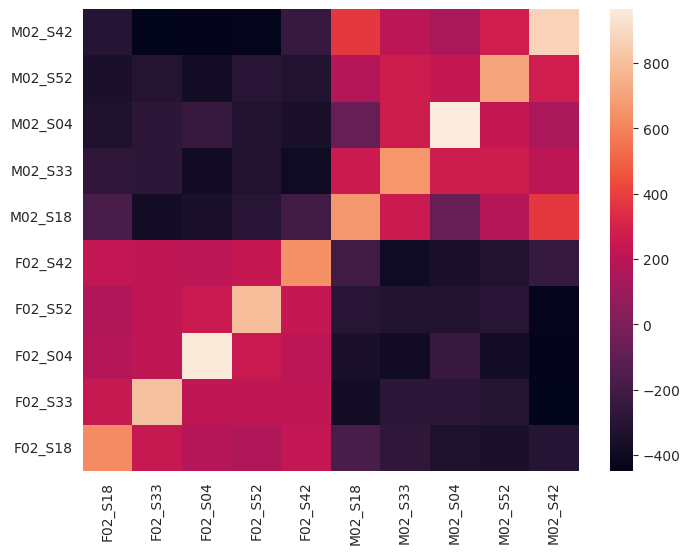

In [ ]:
layer = 0
plot_pp_gram_matrices(p1_filenames, frame_states_p1_test[layer], p2_filenames, frame_states_p2_test[layer])

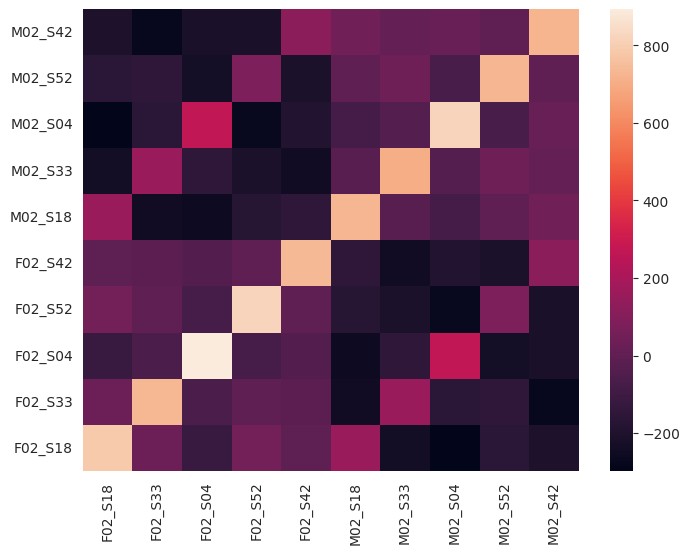

In [ ]:
layer = 7
plot_pp_gram_matrices(p1_filenames, frame_states_p1_test[layer], p2_filenames, frame_states_p2_test[layer])

## CKA similarities between model layers

Representational similarity analyses can also be applied to examine similarities between different layers of the same model, or even different models.

Here we'll visualize similarities between different layers of Wav2Vec2.

In [ ]:
def model_cka(filenames_A, frame_states_A, filenames_B, frame_states_B):
    layers_A = frame_states_A.keys()
    layers_B = frame_states_B.keys()
    cka_similarities = np.full((len(layers_A), len(layers_B)), np.nan)
    for layer_A in frame_states_A.keys():
        for layer_B in frame_states_B.keys():
            layer_states_A = np.array([np.array(frame_states_A[layer_A][fn]).mean(axis=0) for fn in filenames_A])
            layer_states_B = np.array([np.array(frame_states_B[layer_B][fn]).mean(axis=0) for fn in filenames_B])
            cka_similarities[layer_A, layer_B] = cka(gram_linear(layer_states_A), gram_linear(layer_states_B))
    return cka_similarities

For the same recordings, we see several blocks appear where similarities between layers are more similar.

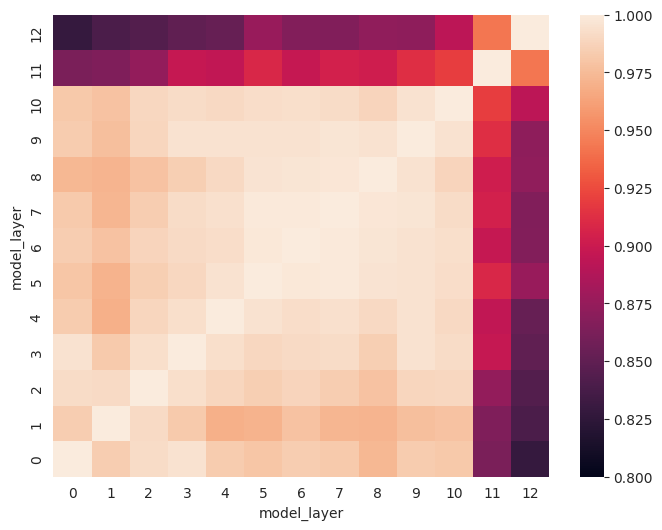

In [ ]:
model_layerwise_cka = model_cka(p1_filenames, frame_states_p1_test,
                                p1_filenames, frame_states_p1_test)

fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(model_layerwise_cka, ax=ax, vmin=0.8, vmax=1)
ax.invert_yaxis()
ax.set_xlabel('model_layer')
ax.set_ylabel('model_layer')
plt.show()

Comparing recordings of the same sentences by two participants, we can confirm what we saw before: similarities for the same sentences across participants are highest in model layers 5-8.

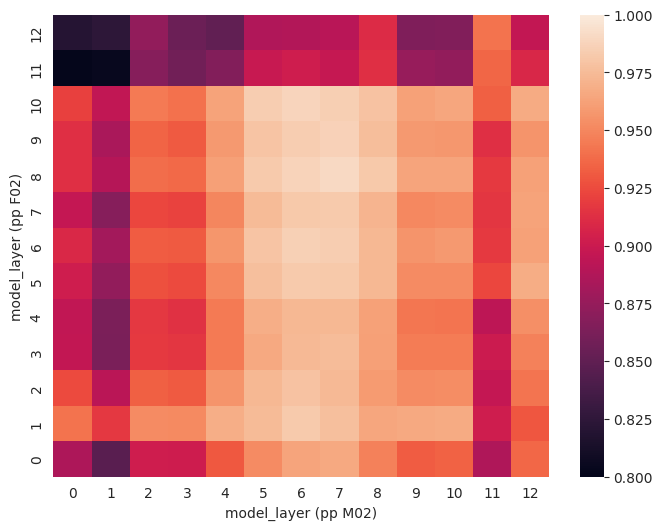

In [ ]:
model_layerwise_cka = model_cka(p1_filenames, frame_states_p1_test,
                                p2_filenames, frame_states_p2_test)

fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(model_layerwise_cka, ax=ax, vmin=0.8, vmax=1)
ax.invert_yaxis()
ax.set_xlabel('model_layer (pp M02)')
ax.set_ylabel('model_layer (pp F02)')
plt.show()